In this example, we'll reproduce (part of) Fig. 4. There we demonstrated that DSA is invariant to smooth geometric transformations, and responds selectively to changes in attractor topology. Note that we're using the netrep package as well so make sure to install that as well, or comment the relevant lines out.

In [1]:
# #install the packages that we haven't added in setup.py
# ! pip install matplotlib
# ! pip install scikit-learn
# ! pip install seaborn
# ! pip install pandas

# #install netrep
# ! git clone https://github.com/ahwillia/netrep
# ! cd netrep #if this does not work, install it via the terminal
# ! pip install -e .
# ! cd ..

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from DSA import DSA
import seaborn as sns
import pandas as pd 
from netrep.metrics import LinearMetric

In [3]:
def generate_w_matrix(device, nNeurons, nBumps,length=40, wWeight=8.0, wShift=2, wScaling=True):
    """
    Generating synaptic connectivity matrix
    
    Inputs
    ------
    wWeight : positive value; sets the strength of the most inhibitory connection
    wShift : synaptic output shift for L and R populations (xi)
    wScaling : scale the raw wWeight by nNeurons and nBumps
    """
    # Calculating synaptic connectivity values #TODO change for diff connect, too small will result in multiple bumps
    # length = nNeurons / (
    #     2.28 * nBumps
    # )  # inhibition length l that produces nBumps (Eq. 47)
    length2 = int(2 * np.ceil(length))
    positions = np.arange(-length2, length2 + 1)  # Only short-range synapses between -2l and 2l
    if wScaling:  # Scale wWeight so bump shape remains the same
        strength = wWeight * nBumps / nNeurons
    else:
        strength = wWeight

    # Cosine-based connectivity function (Eq. 38)
    values = strength * (np.cos((np.pi * positions / length)) - 1) / 2
    values *= np.abs(positions) < 2 * length

    # Adding values to form unshifted row of w matrix. We form the row this way so that
    # synaptic weights are wrapped around the network in case 4 * length > nNeurons
    # (Eq. 127)
    wUnshifted = torch.zeros(nNeurons, device=device)
    for position, w in zip(positions, values):
        wUnshifted[position % nNeurons] += w

    # Form unshifted matrix of dim (nNeurons, nNeurons), then shift and form final matrix
    # of dim (2 * nNeurons, 2 * nNeurons)
    wQuadrant = torch.vstack([wUnshifted.roll(i) for i in range(nNeurons)])
    wMatrix = torch.hstack((wQuadrant.roll(-wShift, 0), wQuadrant.roll(wShift, 0)))
    wMatrix = torch.vstack((wMatrix, wMatrix))

    return wMatrix

def generate_alpha_matrix(neurons,length,alpha,device='cpu',wWeight=8,
                wShift=2,wScaling=True):
    cutoff = int((1-alpha)*length)
    wMatrix = generate_w_matrix(device,neurons+cutoff,1,length,wWeight,wShift,wScaling)
    real_w = torch.zeros((neurons*2,neurons*2),device=device)
    end = 2*neurons + cutoff
    real_w[:neurons,:neurons] = wMatrix[:neurons,:neurons] #top left
    real_w[neurons:,neurons:] = wMatrix[neurons+cutoff:end,neurons+cutoff:end] #bottom right
    real_w[:neurons,neurons:] = wMatrix[:neurons,neurons+cutoff:end] #off diagonals
    real_w[neurons:,:neurons] = wMatrix[neurons+cutoff:end,:neurons]
    return real_w

def position_quantities(nNeurons, nBumps):
    
    """
    Calculate constant quantities used repeatedly to calculate position
    """

    # Position calculation requires extraction of each bump in regions of length
    # splitLength. Neurons at the midway points between bumps may not be included
    # into a region. splitMask indicates which neural positions should not be used,
    # distributing them as evenly as possible throughout the network. For example,
    # for a network with 200 neurons (per population) and 3 bumps has regions of
    # 66 neurons with 2 neural positions unused.
    splitLength = int(np.floor(nNeurons / nBumps))
    splitRemainder = nNeurons % nBumps

    splitExtras = (nNeurons - 1) - np.arange(splitRemainder) * splitLength

    splitMask = np.ones(nNeurons, dtype=bool)
    splitMask[splitExtras] = False

    # centeredOffsets contains the positions of the first neuron in each region
    centeredOffsets = np.arange(nBumps) * splitLength
    if splitRemainder > 1:
        for i in range(splitRemainder - 1):
            centeredOffsets[-(i + 1) :] += 1

    # Converting neural positions to angles that obey the periodicity of the bumps
    # for calculating the circular mean
    angles = 2 * np.pi * nBumps / nNeurons * np.arange(nNeurons)
    cosAngles = np.cos(angles)
    sinAngles = np.sin(angles)

    return (splitMask, centeredOffsets, cosAngles, sinAngles)
def get_position(ss, nNeurons, nBumps, old, quantities):
    
    """
    Find the position of bumps

    Inputs
    ------
    ss : firing rates averaged between populations
    old : old bump positions for matching
    quantities : constants produced by position_quantities

    """

    splitLength = int(np.floor(nNeurons / nBumps))
    splitMask = quantities[0]

    # Compute the circular center of mass to calculate shift, which approximately
    # centers bumps within each extraction region. circularCenter is an average position
    # of all the bumps.
    circularCenter = (
        nNeurons
        / (2 * np.pi * nBumps)
        * circular_mean(ss, quantities[2], quantities[3])
    )
    shift = int(splitLength / 2 - circularCenter)

    
    # Shift activity so position circularCenter becomes position splitLength/2,
    # then apply mask and reshape to extract nBumps regions of length splitLength
    centeredSs = np.roll(ss, shift)[splitMask].reshape((nBumps, -1))
    centeredShifts = quantities[1] - shift

    # Compute linear center of mass for each region and undo shift to determine bump
    # positions
    centers = np.sum(
        centeredSs * np.expand_dims(np.arange(splitLength), 0), 1
    ) / np.sum(centeredSs, 1)
    centers = np.mod(centers + centeredShifts, nNeurons)

    # Reorder bumps if they have moved from one region to the next so that their
    # identities are maintained. This is done by comparing old and positions to
    # determine the ordering that minimizes their mean distance
    if nBumps > 1 and old is not None:
        match = int(
            np.round(
                np.mean(mod_offset((centers - old) / (nNeurons / nBumps), nBumps, -0.5))
            )
        )
        centers = np.roll(centers, match)

    return centers


# mod function with lower range starting at offset
def mod_offset(x, n, offset):
    return (x - offset) % n + offset


# \arctan [(\sum_i w_i \sin\theta_i) / (\sum_i w_i \cos\theta_i)]
# Then shift result to lie between 0 and 2 \pi
def circular_mean(weights, cosAngles, sinAngles):

    return np.mod(
        np.arctan2((weights * sinAngles).sum(), (weights * cosAngles).sum()), 2 * np.pi
    ).item()

class GPUSim:
    """
    A class for simulating a continuous attractor network on GPU
    
    ...
    
    Attributes
    ----------
    device (str) : name of cuda device
    nNeurons (int) : number of neurons in each L and R population (N)
    nBumps (int) : number of activity bumps in the network (M)
    dt (float) : simulation timestep
    tau (float) : time constant
    phiFunction (func) : neural transfer function
    wAttractor (tensor) : connectivity weights
    gsL (array) : synaptic inputs of left neurons
    gsR (array) : synaptic inputs of right neurons
    
    
    Methods
    -------
    evolve_network : one simulation timestep update to network 
    simulate : full simulation network
    movie : produce movie for visualization network
    
    """

    def __init__(
        self,
        device,
        nNeurons,
        nBumps,
        length = 40,
        phiFunction=torch.relu,
        wWeight=8.0,
        wShift=2,
        wAttractor=None,
        wScaling=True,
        restingMag=1.0,
        gammaMultiplier=1.0,
        gNoiseMag=None,
        fano=None,
        dt=0.5,
        tau=10.0,
        alpha = 1.0
    ):
        """
        Initializing GPU sim object
        
        Inputs
        ------
        device : cuda device name
        nNeurons : number of neurons in each population
        nBumps : number of acitivity bumps
        phiFunction : neural transfer function
        wWeight : inhibition weights
        wShift : left and right populations connectivity shifts
        wScaling : scaling connectivity to be proportional to bump number and network size
        restingMag : magnitude of resting input (A)
        gammaMultiplier : rescaling factor for drive coupling strength
        gNoiseMag : standard deviation of input noise
        fano : Fano factor for spiking noise
        dt : simulation timestep
        tau : time constant
        
        """
        self.device = device  # GPU Name, in pytorch convention
        self.nNeurons = nNeurons  # Number of neurons in each population
        self.nBumps = nBumps  # Number of activity bumps
        self.dt = dt  # timestep
        self.tau = tau  # time constant
        self.length = length
        self.phiFunction = phiFunction  # neural activation function

        if wAttractor is not None:  # Check if using predefined connectivity matrix
            self.wAttractor = wAttractor
        else:  # Otherwise creates a new connectivity matrix
            self.wAttractor = generate_alpha_matrix(
                nNeurons,
                length=self.length,
                alpha=alpha,
                wWeight=wWeight,
                wShift=wShift,
                wScaling=wScaling,
                device=device
                )

        # Quantities used for calculating bump position
        self.positionQuantities = position_quantities(nNeurons, nBumps)

        self.restingInput = restingMag * torch.ones(2 * nNeurons, device=device)
        self.gamma = (  # Coupling strength between input drive and network
            0.1
            * gammaMultiplier
            * torch.cat((-torch.ones(nNeurons), torch.ones(nNeurons))).to(device)
        )

        # Setting input noise magnitude
        self.gNoiseMag = gNoiseMag
        if self.gNoiseMag is not None and self.gNoiseMag <= 0.0:
            self.gNoiseMag = None

        # Setting Fano factor for spiking simulations
        self.fano = fano
        if self.fano is not None and self.fano <= 0.0:
            self.fano = None

    def evolve_network(self, gs, ss, deltaGs, b):
        """
        Evolve network by one timestep
        
        Inputs
        ------
        gs : synaptic inputs, concatenated across populations
        ss : firing rates, concatenated across populations
        deltaGs : updates to gs
        b : driving input
        """
        # Converting synaptic inputs to firing rates
        ss = self.phiFunction(gs)

        if self.fano is not None:  # If running spiking simulations (Eq. 128)
            ss = torch.poisson(ss * self.dt / self.fano) * self.fano / self.dt

        # Main dynamical process (Eq. 125)
        deltaGs = -gs + self.restingInput * (1.0 + self.gamma * b)
        deltaGs += torch.matmul(self.wTotal, ss)
        if self.gNoiseMag is not None:
            deltaGs += self.gNoiseMag * torch.randn_like(gs)

        gs += (self.dt / self.tau) * deltaGs

    def simulate(
        self,
        drive,
        tSim,
        pulseMag=1.0,
        pulsePosition=None,
        wNoise=None,
        saveGs=True,
        trackMotion=False,
        stuckThresh=0.01,
        tSetup=1000,
        tPulse=100,
        tStuck=2000,
        tTrack=200,
        tExtra=1000,
    ):
        """
        Simulate the continuous attractor network
        
        Inputs
        ------
        drive : input drive
        tSim : length of the time of simulation
        pulseMag : magnitude of pulse to help start network at certain positions
        pulsePosition : position at which one bump will be initialized
        wNoise (tensor) : noise in the connectivity matrix. Dim (2 * nNeurons, 2 * nNeurons)
        saveGs : to save the synaptic inputs
        trackMotion : whether to monitor bumps circling the network and getting stuck
        stuckThresh : if network position has not exceeded this value in tStuck time, network is stuck
        tSetup : time for network to initialize into a steady position
        tPulse : time of pulses to initialize network
        tStuck : time to be considered stuck
        tTrack : time range for each round of position detection
        tExtra : extra time at the end of simulation
        """

        device = self.device
        nBumps = self.nBumps
        nNeurons = self.nNeurons
        if isinstance(drive, (int, float)):  # constant drive
            self.drive = np.full(tSetup + tSim, drive)
        else:
            self.drive = drive

        if trackMotion:
            trackNow = True
        else:  # If we are not actively tracking bump motion, we get all positions at the end
            trackNow = False
            tTrack = tSim

        # Allocating memory for tracking data
        trackedGsL = torch.zeros((tTrack, nNeurons), device=device)
        trackedGsR = torch.zeros((tTrack, nNeurons), device=device)

        # Structures for accumulating gs and positions at each timestep
        self.gsL = []
        self.gsR = []
        self.positions = np.empty((0, nBumps))

        self.visited = np.zeros(nNeurons, dtype=int)  # visited positions (rounded to nearest integer)
        self.circled = False  # Check if the network has visited every neural position
        self.stuck = False  # Tracking if network is stuck in same position

        # Additional input for initializing bumps
        bumpPeriod = int(nNeurons / nBumps)  # bump distance
        pulseInds = bumpPeriod * np.arange(nBumps)  # initialize multiple bumps
        pulseInds = np.concatenate((pulseInds, nNeurons + pulseInds))  # both populations
        if pulsePosition is None:
            pulseInds += np.random.randint(bumpPeriod)
        else:
            pulseInds += int(pulsePosition % bumpPeriod)

        pulseInputs = torch.zeros(2 * nNeurons, device=device)
        pulseInputs[pulseInds] = pulseMag

        # Initializing random gs and allocating memory for ss and deltaGs
        gs = 0.1 * torch.rand(2 * nNeurons, device=device) + pulseInputs
        ss = torch.zeros_like(gs)
        deltaGs = torch.zeros_like(gs)

        currentPosition = None

        if wNoise is not None:  # If simulating with connectivity noise
            self.wTotal = self.wAttractor + wNoise
        else:
            self.wTotal = self.wAttractor

        for t in range(tSetup):  # Initialize bumps
            self.evolve_network(gs, ss, deltaGs, self.drive[t])

            if t < tPulse:  # Additional synaptic input at fixed locations
                gs += pulseInputs

        t = 0

        # Main simulation
        while t < tSim:

            # Evolve the network
            self.evolve_network(gs, ss, deltaGs, self.drive[t + tSetup])

            # Save synaptic inputs of left and right populations
            if saveGs:
                self.gsL.append(torch.clone(gs[:nNeurons]))
                self.gsR.append(torch.clone(gs[nNeurons:]))

            trackedGsL[t % tTrack] = torch.clone(gs[:nNeurons])
            trackedGsR[t % tTrack] = torch.clone(gs[nNeurons:])

            # Detecting bump positions and tracking bump motion. This is done intermittently to reduce time transferring tensors to CPU
            if (t + 1) % tTrack == 0:  # Tracking period
                trackedSs = (
                    ((self.phiFunction(trackedGsL) + self.phiFunction(trackedGsR)) / 2)
                    .cpu()
                    .numpy()
                )  # Convert synaptic inputs to activity averaged between populations

                trackedPositions = []
                for ss in trackedSs:  # For all activities tracked, find position and append
                    currentPosition = get_position(
                        ss, nNeurons, nBumps, currentPosition, self.positionQuantities
                    )
                    trackedPositions.append(currentPosition)

                trackedPositions = np.array(trackedPositions)
                self.positions = np.vstack((self.positions, trackedPositions))

                if trackNow:  # If we need to check bumps circling the network or getting stuck
                    trackedNeurons = np.unique(trackedPositions.astype(int))
                    self.visited[trackedNeurons] = 1

                    if (
                        self.visited.sum() == nNeurons
                    ):  # Check if we have visited all neural positions (rounded to integers)
                        self.circled = True
                        trackNow = False
                        t = tSim - tExtra  # Simulate tExtra more time steps
                        continue
                    if t >= tStuck and np.any(
                        np.abs(self.positions[-tStuck] - self.positions[-1])
                        < stuckThresh
                    ):  # Check if any bump has moved less than stuckThresh in the last tStuck timesteps
                        self.stuck = True
                        trackNow = False
                        t = tSim - tExtra  # Simulate tExtra more time steps
                        continue

            t += 1

        if saveGs:
            self.gsL = torch.stack(self.gsL).cpu().numpy()
            self.gsR = torch.stack(self.gsR).cpu().numpy()


In [ ]:
def plot_results(ts,nruns,diffs_dsa,diffs_proc,parameter):           
    df = pd.DataFrame(dict(ts=np.tile(ts,nruns),
                       diffs_dsa=diffs_dsa.flatten(),diffs_proc=diffs_proc.flatten()))
    palette = None 
    errorbar = 'se'
    hue = None
    g = sns.lineplot(data=df, x="ts", y="diffs_dsa", hue=hue,
                    palette=palette,errorbar=errorbar,c="blue",marker='o',label="DSA")
    k = sns.lineplot(data=df, x="ts", y="diffs_proc", hue=hue,
                    palette=palette,errorbar=errorbar,c="orange",marker='o',label="Procrustes")

    plt.xlabel(parameter)
    plt.ylabel(rf"$D({parameter}={ts[0]},\cdot)$")


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
comparison_shape = LinearMetric(center_columns=True,alpha=0,score_method='angular')
#define our transformations (sigmoid,linear scaling)
def sigmoid(x,beta):
    return 1 / (1 + torch.exp(-beta * torch.tensor(x)))
def scale(x,scale=2,beta=0.2):
    #draw random scales for each axis of the attractor, then scale the data
    #d = np.diag(np.random.choice([1,scale],size=x.shape[-1]))
    x = sigmoid(x,beta)
    d = np.diag(np.repeat(scale,x.shape[-1]))
    return x @ d

#parameters for the run here
nruns = 10 #will do multiple tests and average over
n_delays = 10
rank = None
diffeo = sigmoid
nneurons = 100 #here we'll keep them fixed across runs, but we varied them in the original code
burn_in = 200

if diffeo == scale:
    ts = np.arange(1,5,0.5)
    name = "scale"
    parameter = "s"
elif diffeo == sigmoid:
    ts = np.arange(0.1,4,0.5)
    name = "sigmoid"
    parameter = r"$\beta$"
print(device)

cpu


In [ ]:
from sklearn.decomposition import PCA

diffs_dsa = np.zeros((nruns,ts.size))
diffs_proc = np.zeros((nruns,ts.size))

for j in range(nruns):
    print(f"on run {j}")
    #we'll vary the size of the bump, which changes the extrinsic dimensionality of the ring
    length = np.random.randint(int(0.55*nneurons),int(0.65*nneurons)) 
    sim = GPUSim(device, nneurons, 1,length, wScaling=False,gNoiseMag=0.01) #only 1 bump
    sim.simulate(2,2000,wNoise=0.0) #simulate wth a drive of 2 for 3000 timesteps
    run_data = sim.gsR[burn_in:] #remove the burn-in period
    d0 = diffeo(run_data,ts[0]) #compare all to d0 (the smallest scale transform)
    d0 = PCA(n_components=15).fit_transform(d0)
    data = []
    for i,beta in enumerate(ts):
        d = diffeo(run_data,beta)
        pca = PCA(n_components=15)
        d = pca.fit_transform(d)
        # print(np.cumsum(pca.explained_variance_ratio_))
        data = []
        data.append(d)
        proc_score = comparison_shape.fit_score(d, d0)
        diffs_proc[j,i] = proc_score
    print("DSA")
    #we're doing 1-to-many analysis here!
    dsa = DSA(d0,data,n_delays=n_delays,rank=rank,device=device,verbose=True,iters=500,lr=0.01,score_method='wasserstein')
    dsa_score = dsa.fit_score()
    # print(dsa_score.shape)
    diffs_dsa[j,:] = dsa_score


on run 0
DSA


Fitting DMDs: 100%|██████████| 1/1 [00:00<00:00, 26.63it/s]


Pre-computing eigenvalues for Wasserstein distance...


Computing DMD similarities: 100%|██████████| 1/1 [00:00<00:00, 199.13it/s]

on run 1


DSA


Fitting DMDs: 100%|██████████| 1/1 [00:00<00:00, 25.73it/s]


Pre-computing eigenvalues for Wasserstein distance...


Computing DMD similarities: 100%|██████████| 1/1 [00:00<00:00, 238.37it/s]

on run 2



/var/folders/sh/r0d61tjn42s4mc3nxqb0hhq00000gn/T/ipykernel_74501/1197694459.py:120: RuntimeWarning: invalid value encountered in divide
  centers = np.sum(


DSA


Fitting DMDs: 100%|██████████| 1/1 [00:00<00:00, 21.33it/s]


Pre-computing eigenvalues for Wasserstein distance...


Computing DMD similarities: 100%|██████████| 1/1 [00:00<00:00, 258.48it/s]

on run 3



/var/folders/sh/r0d61tjn42s4mc3nxqb0hhq00000gn/T/ipykernel_74501/1197694459.py:120: RuntimeWarning: invalid value encountered in divide
  centers = np.sum(


DSA


Fitting DMDs: 100%|██████████| 1/1 [00:00<00:00, 18.51it/s]


Pre-computing eigenvalues for Wasserstein distance...


Computing DMD similarities: 100%|██████████| 1/1 [00:00<00:00, 220.03it/s]

on run 4



/var/folders/sh/r0d61tjn42s4mc3nxqb0hhq00000gn/T/ipykernel_74501/1197694459.py:120: RuntimeWarning: invalid value encountered in divide
  centers = np.sum(


DSA


Fitting DMDs: 100%|██████████| 1/1 [00:00<00:00, 21.92it/s]


Pre-computing eigenvalues for Wasserstein distance...


Computing DMD similarities: 100%|██████████| 1/1 [00:00<00:00, 252.79it/s]

on run 5



/var/folders/sh/r0d61tjn42s4mc3nxqb0hhq00000gn/T/ipykernel_74501/1197694459.py:120: RuntimeWarning: invalid value encountered in divide
  centers = np.sum(


DSA


Fitting DMDs: 100%|██████████| 1/1 [00:00<00:00, 22.40it/s]


Pre-computing eigenvalues for Wasserstein distance...


Computing DMD similarities: 100%|██████████| 1/1 [00:00<00:00, 226.50it/s]

on run 6


DSA


Fitting DMDs: 100%|██████████| 1/1 [00:00<00:00, 10.81it/s]

Pre-computing eigenvalues for Wasserstein distance...



Computing DMD similarities: 100%|██████████| 1/1 [00:00<00:00, 286.05it/s]


on run 7


/var/folders/sh/r0d61tjn42s4mc3nxqb0hhq00000gn/T/ipykernel_74501/1197694459.py:120: RuntimeWarning: invalid value encountered in divide
  centers = np.sum(


DSA


Fitting DMDs: 100%|██████████| 1/1 [00:00<00:00, 26.60it/s]


Pre-computing eigenvalues for Wasserstein distance...


Computing DMD similarities: 100%|██████████| 1/1 [00:00<00:00, 220.12it/s]

on run 8



/var/folders/sh/r0d61tjn42s4mc3nxqb0hhq00000gn/T/ipykernel_74501/1197694459.py:120: RuntimeWarning: invalid value encountered in divide
  centers = np.sum(


DSA


Fitting DMDs: 100%|██████████| 1/1 [00:00<00:00, 24.12it/s]


Pre-computing eigenvalues for Wasserstein distance...


Computing DMD similarities: 100%|██████████| 1/1 [00:00<00:00, 254.26it/s]

on run 9



/var/folders/sh/r0d61tjn42s4mc3nxqb0hhq00000gn/T/ipykernel_74501/1197694459.py:120: RuntimeWarning: invalid value encountered in divide
  centers = np.sum(


DSA


Fitting DMDs: 100%|██████████| 1/1 [00:00<00:00, 20.08it/s]


Pre-computing eigenvalues for Wasserstein distance...


Computing DMD similarities: 100%|██████████| 1/1 [00:00<00:00, 241.30it/s]


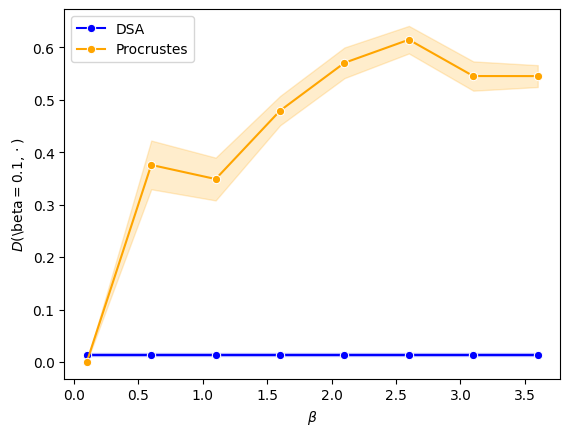

In [ ]:
plot_results(ts,nruns,diffs_dsa,diffs_proc,parameter)

Now that we got that working, let's try changing the attractor topology. 

In [8]:
def generate_random_flip_signal(magnitude, min_flip_interval, max_flip_interval, total_time,noise_scale=0.1):
    signal = np.ones(total_time) * magnitude
    current_time = 0
    # Loop until the total time is reached
    while current_time < total_time:
        # Generate a random flip interval
        flip_interval = np.random.randint(min_flip_interval, max_flip_interval)
        # Updte the current time
        current_time += flip_interval
        # Check if the current time is within the total time
        if current_time < total_time:
            # Flip the signal
            signal[current_time:] *= -1
    signal += noise_scale * np.random.normal(size=total_time)
    return signal

In [36]:
nruns = 1
ndelays = 10
rank = 16
da = 0.1
tSetup = 1000
time = 8000
total_time = tSetup + time
mag = 1
noise_scale=0.5
#describes intervals between switching the direction of the pulse
min_interval = 100
max_interval = 4000

gnoise = 0.0
wnoise = 0.0
alphas = np.arange(0,1+da,da)
lneurons = 100 #varying 
hneurons = 150
diffs_dsa = np.zeros((nruns,alphas.size))
diffs_proc = np.zeros((nruns,alphas.size))

for k in range(nruns):
    print(f"on run {k}")
    neurons = np.random.randint(lneurons,hneurons)
    length = np.random.randint(int(0.55*neurons),int(0.65*neurons)) #60 avg

    drive = generate_random_flip_signal(mag, min_interval, max_interval, total_time, noise_scale)
    sim = GPUSim(device, neurons, 1,length, wScaling=False,gNoiseMag=gnoise,alpha=alphas[0])
    sim.simulate(drive,time,wNoise=wnoise)
    d0 = torch.relu(torch.tensor(sim.gsR))
    data = []
    for i,alpha in enumerate(alphas):
        print(alpha)
        sim = GPUSim(device, neurons, 1,length, wScaling=False,gNoiseMag=gnoise,alpha=alpha)

        sim.simulate(drive,time,wNoise=wnoise)
        d = torch.relu(torch.tensor(sim.gsR))
        pca = PCA(n_components=15)
        d = pca.fit_transform(d)
        print(np.cumsum(pca.explained_variance_ratio_))
        data.append(d) 
        
        diffs_proc[k,i] = comparison_shape.fit_score(d0,d)

    dsa = DSA(d0,data,n_delays=n_delays,rank=rank,device=device,verbose=True,score_method='wasserstein')
    dsa_score = dsa.fit_score()
    print(dsa_score.shape)
    diffs_dsa[k,:] = dsa_score


on run 0
0.0
[0.25369717 0.45654168 0.61520462 0.73780483 0.82856849 0.88754471
 0.92879732 0.95389112 0.9700081  0.97930919 0.9854652  0.98951094
 0.99130669 0.99260625 0.99388587]
0.1
[0.19048048 0.32985884 0.45220731 0.56204825 0.64656907 0.72225737
 0.78645379 0.8387057  0.88046408 0.91326671 0.93781133 0.95550473
 0.96743091 0.9754896  0.98078049]
0.2
[0.45967021 0.61126547 0.72997665 0.81298848 0.87317053 0.91252379
 0.94365227 0.96314694 0.9755494  0.98291577 0.98769552 0.99125876
 0.99318308 0.99419832 0.99518581]
0.30000000000000004
[0.23221853 0.43225934 0.59113581 0.71408954 0.80805437 0.87151854
 0.91953221 0.94998535 0.96778991 0.97754717 0.98465794 0.98913341
 0.99109576 0.99240676 0.99366563]
0.4
[0.19048048 0.32985886 0.45220733 0.56204827 0.64656909 0.72225738
 0.7864538  0.83870572 0.8804641  0.91326672 0.93781133 0.95550473
 0.96743092 0.9754896  0.98078049]
0.5
[0.19227735 0.33898624 0.46312195 0.57362714 0.66190565 0.7406905
 0.80478509 0.85580001 0.89642329 0.9268

/var/folders/sh/r0d61tjn42s4mc3nxqb0hhq00000gn/T/ipykernel_74501/1197694459.py:120: RuntimeWarning: invalid value encountered in divide
  centers = np.sum(


[0.1106887  0.21309875 0.30240264 0.38665383 0.45767216 0.52288068
 0.58136988 0.6394324  0.69465593 0.74241949 0.78972251 0.82641405
 0.86284668 0.88916518 0.91540882]


Fitting DMDs: 100%|██████████| 11/11 [00:00<00:00, 23.75it/s]


Pre-computing eigenvalues for Wasserstein distance...


Computing DMD similarities: 100%|██████████| 11/11 [00:00<00:00, 1261.34it/s]

(11,)


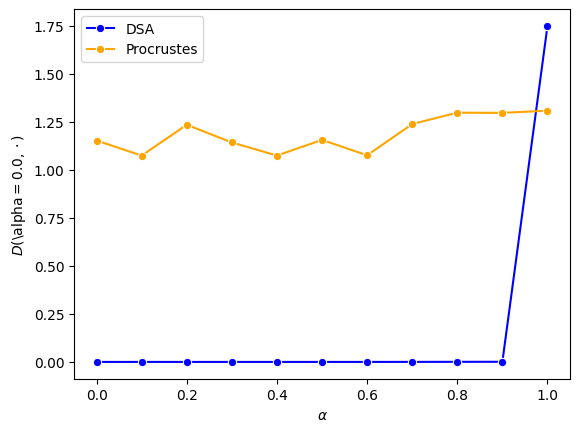

In [37]:
plot_results(alphas,nruns,diffs_dsa,diffs_proc,r"$\alpha$")
